In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [24]:
class Kernel(object):
    """
    Base class for kernel function
    """

    def _pairwise(self, x, y):
        """
        all pairs of x and y
        Parameters
        ----------
        x : (sample_size, n_features)
            input
        y : (sample_size, n_features)
            another input
        Returns
        -------
        output : tuple
            two array with shape (sample_size, sample_size, n_features)
        """
        return (
            np.tile(x, (len(y), 1, 1)).transpose(1, 0, 2),
            np.tile(y, (len(x), 1, 1))
        )
    
class RBF(Kernel):

    def __init__(self, params):
        """
        construct Radial basis kernel function
        Parameters
        ----------
        params : (ndim + 1,) ndarray
            parameters of radial basis function
        Attributes
        ----------
        ndim : int
            dimension of expected input data
        """
        assert params.ndim == 1
        self.params = params
        self.ndim = len(params) - 1

    def __call__(self, x, y, pairwise=True):
        """
        calculate radial basis function
        k(x, y) = c0 * exp(-0.5 * c1 * (x1 - y1) ** 2 ...)
        Parameters
        ----------
        x : ndarray [..., ndim]
            input of this kernel function
        y : ndarray [..., ndim]
            another input
        Returns
        -------
        output : ndarray
            output of this radial basis function
        """
        assert x.shape[-1] == self.ndim
        assert y.shape[-1] == self.ndim
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        return self.params[0] * np.exp(-0.5 * np.sum(d, axis=-1))

    def derivatives(self, x, y, pairwise=True):
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        delta = np.exp(-0.5 * np.sum(d, axis=-1))
        deltas = -0.5 * (x - y) ** 2 * (delta * self.params[0])[:, :, None]
        return np.concatenate((np.expand_dims(delta, 0), deltas.T))

    def update_parameters(self, updates):
        self.params += updates
        

class RelevanceVectorClassifier(object):

    def __init__(self, kernel, alpha=1.):
        """
        construct relevance vector classifier
        Parameters
        ----------
        kernel : Kernel
            kernel function to compute components of feature vectors
        alpha : float
            initial precision of prior weight distribution
        """
        self.kernel = kernel
        self.alpha = alpha

    def _sigmoid(self, a):
        return np.tanh(a * 0.5) * 0.5 + 0.5

    def _map_estimate(self, X, t, w, n_iter=10):
        for _ in range(n_iter):
            y = self._sigmoid(X @ w)
            g = X.T @ (y - t) + self.alpha * w
            H = (X.T * y * (1 - y)) @ X + np.diag(self.alpha)
            w -= np.linalg.solve(H, g)
        return w, np.linalg.inv(H)

    def fit(self, X, t, iter_max=100):
        """
        maximize evidence with respect ot hyperparameter
        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input
        t : (sample_size,) ndarray
            corresponding target
        iter_max : int
            maximum number of iterations
        Attributes
        ----------
        X : (N, n_features) ndarray
            relevance vector
        t : (N,) ndarray
            corresponding target
        alpha : (N,) ndarray
            hyperparameter for each weight or training sample
        cov : (N, N) ndarray
            covariance matrix of weight
        mean : (N,) ndarray
            mean of each weight
        """
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        assert t.ndim == 1
        Phi = self.kernel(X, X)
        N = len(t)
        self.alpha = np.zeros(N) + self.alpha
        mean = np.zeros(N)
        for _ in range(iter_max):
            param = np.copy(self.alpha)
            mean, cov = self._map_estimate(Phi, t, mean, 10)
            gamma = 1 - self.alpha * np.diag(cov)
            self.alpha = gamma / np.square(mean)
            np.clip(self.alpha, 0, 1e10, out=self.alpha)
            if np.allclose(param, self.alpha):
                break
        mask = self.alpha < 1e8
        self.X = X[mask]
        self.t = t[mask]
        self.alpha = self.alpha[mask]
        Phi = self.kernel(self.X, self.X)
        mean = mean[mask]
        self.mean, self.covariance = self._map_estimate(Phi, self.t, mean, 100)

    def predict(self, X):
        """
        predict class label
        Parameters
        ----------
        X : (sample_size, n_features)
            input
        Returns
        -------
        label : (sample_size,) ndarray
            predicted label
        """
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        phi = self.kernel(X, self.X)
        label = (phi @ self.mean > 0).astype(np.int)
        return label

    def predict_proba(self, X):
        """
        probability of input belonging class one
        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input
        Returns
        -------
        proba : (sample_size,) ndarray
            probability of predictive distribution p(C1|x)
        """
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        phi = self.kernel(X, self.X)
        mu_a = phi @ self.mean
        var_a = np.sum(phi @ self.covariance * phi, axis=1)
        return self._sigmoid(mu_a / np.sqrt(1 + np.pi * var_a / 8))

class BayesianLogisticRegression(object):
    """
    Logistic regression model
    w ~ Gaussian(0, alpha^(-1)I)
    y = sigmoid(X @ w)
    t ~ Bernoulli(t|y)
    """

    def __init__(self, alpha:float=1.):
        self.alpha = alpha
    
    def _sigmoid(self, a):
        return np.tanh(a * 0.5) * 0.5 + 0.5

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100):
        """
        bayesian estimation of logistic regression model
        using Laplace approximation
        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
            binary 0 or 1
        max_iter : int, optional
            maximum number of paramter update iteration (the default is 100)
        """
        w = np.zeros(np.size(X, 1))
        eye = np.eye(np.size(X, 1))
        self.w_mean = np.copy(w)
        self.w_precision = self.alpha * eye
        for _ in range(max_iter):
            w_prev = np.copy(w)
            y = self._sigmoid(X @ w)
            grad = X.T @ (y - t) + self.w_precision @ (w - self.w_mean)
            hessian = (X.T * y * (1 - y)) @ X + self.w_precision
            try:
                w -= np.linalg.solve(hessian, grad)
            except np.linalg.LinAlgError:
                break
            if np.allclose(w, w_prev):
                break
        self.w_mean = w
        self.w_precision = hessian
        

    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging class 1
        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        Returns
        -------
        (N,) np.ndarray
            probability of positive
        """
        mu_a = X @ self.w_mean
        var_a = np.sum(np.linalg.solve(self.w_precision, X.T).T * X, axis=1)
        return self._sigmoid(mu_a / np.sqrt(1 + np.pi * var_a / 8))

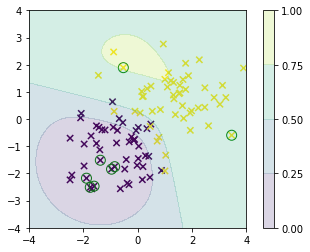

In [25]:
#RVM for classification
def create_toy_data():
    x0 = np.random.normal(size=100).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=100).reshape(-1, 2) + 1.
    x = np.concatenate([x0, x1])
    y = np.concatenate([np.zeros(50), np.ones(50)]).astype(np.int)
    return x, y

x_train, y_train = create_toy_data()
model = RelevanceVectorClassifier(RBF(np.array([1., 0.5, 0.5])))
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contourf(x0, x1, model.predict_proba(x).reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
import pandas as pd
dataApsVar = pd.read_csv("/data/fjsdata/physionet/eICU-CRD/apacheApsVar.csv")    # 读入包含急性生理指标（APS）的表
dataPredVar = pd.read_csv("/data/fjsdata/physionet/eICU-CRD/apachePredVar.csv")  # 读入包含慢性疾病，年龄等指标的表
dataPatientResult =  pd.read_csv("/data/fjsdata/physionet/eICU-CRD/apachePatientResult.csv")   # 读入包含死亡率及住院时间标签的表
data1ApsVar = dataApsVar  # 包含APACHE IV中的所有生理指标
data1ApsVar.drop(columns=["apacheapsvarid"], inplace=True)  # 去掉无关的"apacheapsvarid"
data1PredVar = dataPredVar[['age','thrombolytics','aids','hepaticfailure','lymphoma','metastaticcancer',
                            'leukemia','immunosuppression','cirrhosis','electivesurgery','readmit','visitnumber']]  # 包含年龄及慢性疾病特征
data1ApsVar = pd.concat([data1ApsVar, data1PredVar], axis=1)  # 拼接apacheApsVar和apachePredVar两个表
data1ApsVar['age'].fillna(-1, inplace=True)  # 用-1填补NAN值,因为age包含NAN值
data1ApsVar['electivesurgery'].fillna(0, inplace=True)  # 用-1填补急需手术中的NAN值
data1ApsVar.set_index(["patientunitstayid"], inplace=True)  # 将patientunitstayid设置成index
admit_diagnosis = dataPredVar.loc[:, ['admitdiagnosis']]  # 加入诊断文本
admit_diagnosis.fillna('-1', inplace=True)  # 用-1填补NAN值
admit_diagnosis = LabelEncoder().fit_transform(admit_diagnosis)  # 对诊断文本进行编码
data1ApsVar['diagnosis'] = admit_diagnosis
neg_index = dataPatientResult[dataPatientResult['predictedhospitallos'].values == -1].index  # 找到apachePatientResult中预测结果不全的索引
dataPatientResult.drop(index=neg_index, inplace=True)  # 将其删除
saveid = dataPatientResult['patientunitstayid']  # 需要保留的id,原因是result表含有较少数据
saveid.drop_duplicates(keep='first',inplace=True)  # 因为含有APACHE IV和IVA两个版本的数据，因此去除重复id
data = data1ApsVar.loc[saveid.values]  # 得到最终数据
gp = dataPatientResult.groupby(['apacheversion'])
val = []
for i in gp:
    val.append(i[1])
val[1].index = data.index   # 按照IV和IVa两个版本分离
data_number_label = val[1]['actualiculos']  # 取icu住院时间真值标签
X_train, X_test, y_train, y_test = train_test_split(data, data_number_label, test_size=0.33, random_state=0)
regr = RandomForestRegressor(n_estimators=10, max_depth=13, min_samples_split=110,  min_samples_leaf=20, max_features='sqrt', oob_score=True, random_state=10)
regr.fit(X_train, y_train.ravel())
re = regr.predict(X_test)
mae_predict = mean_absolute_error(y_test, re)
print("maeScore:\n", mae_predict)  # 计算EV,MAE,R2回归指标
r2_predict = r2_score(y_test, re)
print("r2Score:\n", r2_predict)
ev_predict = explained_variance_score(y_test, re)
print("evScore:\n", ev_predict)

/root/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


maeScore:
 1.9800402916649287
r2Score:
 0.11487306598986724
evScore:
 0.11494444738777587


/root/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
dataApsVar = pd.read_csv("/data/fjsdata/physionet/eICU-CRD/apacheApsVar.csv")  # 读入包含急性生理指标（APS）的表
dataPredVar = pd.read_csv("/data/fjsdata/physionet/eICU-CRD/apachePredVar.csv")  # 读入包含慢性疾病，年龄等指标的表
dataPatientResult = pd.read_csv("/data/fjsdata/physionet/eICU-CRD/apachePatientResult.csv")  # 读入包含死亡率及住院时间标签的表
data1ApsVar = dataApsVar  # 包含APACHE IV中的所有生理指标
data1ApsVar.drop(columns=["apacheapsvarid"], inplace=True)  # 去掉无关的"apacheapsvarid"
data1PredVar = dataPredVar[['age','thrombolytics','aids','hepaticfailure','lymphoma','metastaticcancer',
                            'leukemia','immunosuppression','cirrhosis','electivesurgery','readmit','visitnumber']]  # 包含年龄及慢性疾病特征
data1ApsVar = pd.concat([data1ApsVar, data1PredVar], axis=1)  # 拼接apacheApsVar和apachePredVar两个表
data1ApsVar['age'].fillna(-1, inplace=True)  # 用-1填补NAN值,因为age包含NAN值
data1ApsVar['electivesurgery'].fillna(0, inplace=True)  # 用0填补急需手术中的NAN值
data1ApsVar.set_index(["patientunitstayid"], inplace=True)  # 将patientunitstayid设置成index
admit_diagnosis = dataPredVar.loc[:, ['admitdiagnosis']]  # 加入诊断文本
admit_diagnosis.fillna('-1', inplace=True)  # 用-1填补NAN值
admit_diagnosis = LabelEncoder().fit_transform(admit_diagnosis)  # 对诊断文本进行编码
data1ApsVar['diagnosis'] = admit_diagnosis
neg_index = dataPatientResult[dataPatientResult['predictedhospitallos'].values == -1].index  # 找到apachePatientResult中预测结果不全的索引
dataPatientResult.drop(index=neg_index, inplace=True)  # 将其删除
saveid = dataPatientResult['patientunitstayid']  # 需要保留的id
saveid.drop_duplicates(keep='first',inplace=True)  # 因为含有APACHE IV和IVA两个版本的数据，因此去除重复id
data = data1ApsVar.loc[saveid.values]  # 得到最终数据
gp = dataPatientResult.groupby(['apacheversion'])
val = []
for i in gp:
    val.append(i[1])
val[1].index = data.index  # 按照IV和IVa两个版本分离
data_number_label = LabelEncoder().fit_transform(val[1]['actualicumortality'])  # 取IVa版本的ICU死亡率真实标签
data_number_label2 = LabelEncoder().fit_transform(val[1]['actualhospitalmortality'])  # 取医院死亡率真实标签
X_train, X_test, y_train, y_test = train_test_split(data, data_number_label, test_size=0.33, random_state=0)  # 划分训练测试集
clf = RandomForestClassifier(n_estimators=10,max_depth=13, min_samples_split=110,  min_samples_leaf=20,
                             max_features='sqrt' ,oob_score=True,random_state=10)  # 最优的RF参数
clf.fit(X_train, y_train)  # 训练分类器
predictproba = clf.predict_proba(X_test)[:, 1]
aucscore = roc_auc_score(y_test, predictproba)  # 进行AUC计算
print("AUC_Score:\n", aucscore)
predicts = clf.predict(X_test)
table = pd.crosstab(y_test, predicts, rownames=['actual'], colnames=['preds'])
print(table)
acc = accuracy_score(y_test, predicts)
print("ACC_Score:\n", acc)

/root/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC_Score:
 0.8882543219835977
preds       0    1
actual            
0       42350  119
1        2177  312
ACC_Score:
 0.9489301125494907


/root/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/root/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/root/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
